In [1]:
!pip install opencv-python-headless matplotlib numpy


In [2]:
!pip install pybullet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 18.4 MB/s eta 0:00:00m eta 0:00:0136m0:00:01


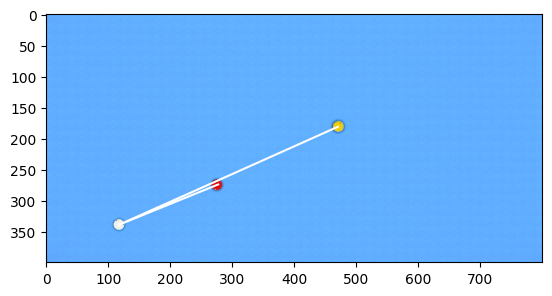

In [29]:
# 탑뷰 이미지를 분석하여 경로 계산 및 시각화

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 불러오기
img = cv2.imread("/home/qpitprj/qfit_31111/mansoon/ModelTraining/ResultImage&Text/billiard_result.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 공의 위치 찾기 (간단한 컬러 필터링 예시)
red_ball = cv2.inRange(img, (30, 30, 150), (50, 50, 255))        # 빨간색 공 필터
white_ball = cv2.inRange(img, (220, 220, 220), (255, 255, 255))  # 흰색 공 필터
yellow_ball = cv2.inRange(img, (30, 180, 180), (50, 255, 255))   # 노란색 공 필터

# 공의 중심 좌표 계산
def find_center(mask):
    moments = cv2.moments(mask)
    if moments['m00'] != 0:
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
        return (cx, cy)
    else:
        return None

# 각 공의 중심 좌표
red_center = find_center(red_ball)
white_center = find_center(white_ball)
yellow_center = find_center(yellow_ball)

# 경로 계산 및 시각화
# (이 부분은 물리 엔진 또는 사용자의 커스텀 계산 로직에 따라 달라질 수 있음)
# 예시: 흰 공에서 노란 공을 거쳐 빨간 공을 치는 경로
if white_center and yellow_center and red_center:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.plot([red_center[0], white_center[0], yellow_center[0]], [red_center[1], white_center[1], yellow_center[1]], 'w-')
    plt.show()

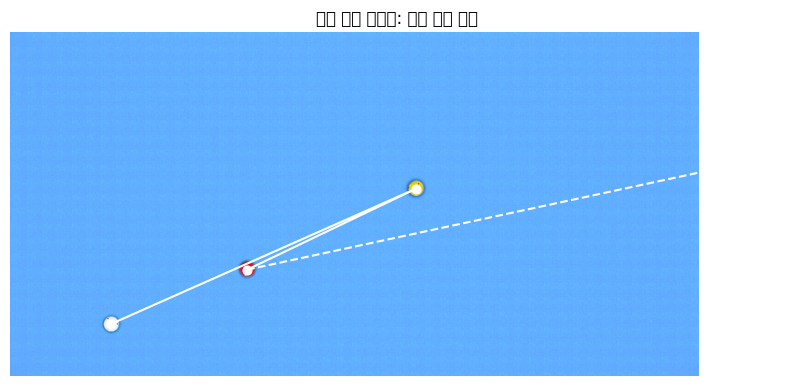

In [2]:
# 탑뷰 좌표와 이미지 값을 참고하여 경로 계산(쿠션 반사를 적용) 및 시각화

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 당구대 크기 및 출력 이미지 크기 설정
WIDTH = 840  # 출력 이미지 너비
HEIGHT = 420  # 출력 이미지 높이
TABLE_WIDTH_MM = 800  # 실제 테이블 너비 (mm)
TABLE_HEIGHT_MM = 400  # 실제 테이블 높이 (mm)

# 파일 경로 설정
text_path = "/home/qpitprj/qfit_31111/mansoon/ModelTraining/ResultImage&Text/billiard_label.txt"
image_path = "/home/qpitprj/qfit_31111/mansoon/ModelTraining/ResultImage&Text/billiard_result.png"

# 공의 위치 정보 읽어오기 함수
def read_positions(file_path):
    positions = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            positions[parts[0]] = (int(parts[1]), int(parts[2]))
    return positions

positions = read_positions(text_path)

# 이미지 불러오기
img = cv2.imread(image_path)
if img is None:
    raise ValueError(f"이미지 파일을 불러올 수 없습니다: {image_path}")

# 공의 좌표 설정 (스케일 불필요)
red_center = positions['red_ball']
white_center = positions['white_ball']
yellow_center = positions['yellow_ball']

# 경로 시각화
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# 흰 공에서 노란 공을 거쳐 빨간 공을 치는 경로
plt.plot([white_center[0], yellow_center[0], red_center[0]], [white_center[1], yellow_center[1], red_center[1]], 'w-')

# 쿠션 반사 계산 함수
def calculate_cushion_hit_and_reflection(ball_pos, target_pos, table_size, cushion_gap=20):
    angle = np.arctan2(target_pos[1] - ball_pos[1], target_pos[0] - ball_pos[0])
    for length in range(1000):
        x = int(ball_pos[0] + length * np.cos(angle))
        y = int(ball_pos[1] + length * np.sin(angle))
        if x <= cushion_gap or x >= table_size[0] - cushion_gap or y <= cushion_gap or y >= table_size[1] - cushion_gap:
            reflection_angle = angle + np.pi / 2
            return (x, y), reflection_angle

# 쿠션 반사 후의 경로 계산
hit_pos, ref_angle = calculate_cushion_hit_and_reflection(white_center, red_center, (WIDTH, HEIGHT))

# 쿠션 반사 후 경로 시각화
plt.plot([red_center[0], hit_pos[0] + 100 * np.cos(ref_angle)], [red_center[1], hit_pos[1] + 100 * np.sin(ref_angle)], 'w--')

# 공의 위치 시각화
plt.scatter(*zip(red_center, white_center, yellow_center, hit_pos), c='w', s=40)
plt.title('당구 경로 시각화: 쿠션 반사 포함')
plt.axis('off')
plt.show()


In [3]:
# PyBullet 당구 시뮬레이션

import pybullet as p
import pybullet_data
import time

# PyBullet 시뮬레이션 환경 설정
physicsClient = p.connect(p.DIRECT)  # 비시각적 모드, 대안으로 p.GUI는 시각적 모드(코랩애서 미지원)
if physicsClient < 0:
    raise RuntimeError("PyBullet physics server에 연결할 수 없습니다.")

# 중력 설정
p.setGravity(0, 0, -10)

# PyBullet 데이터 경로 추가
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# 당구대 로딩, 당구대의 URDF 파일이 필요합니다
try:
    tableId = p.loadURDF("/home/qpitprj/qfit_31111/mansoon/scenario01/billiard_table.urdf", basePosition=[0, 0, 0])
except Exception as e:
    raise FileNotFoundError(f"당구대 URDF 파일을 로드할 수 없습니다: {str(e)}")

# 당구공 로딩 및 위치 설정, 각 공에 대한 URDF 파일이 필요합니다
try:
    red_ball = p.loadURDF("/home/qpitprj/qfit_31111/mansoon/scenario01/billiard_red_ball.urdf", basePosition=[0, 0.5, 0.1], globalScaling=1.1)
    white_ball = p.loadURDF("/home/qpitprj/qfit_31111/mansoon/scenario01/billiard_white_ball.urdf", basePosition=[-0.5, 0, 0.1], globalScaling=1.1)
    yellow_ball = p.loadURDF("/home/qpitprj/qfit_31111/mansoon/scenario01/billiard_yellow_ball.urdf", basePosition=[0.5, 0, 0.1], globalScaling=1.1)
except Exception as e:
    raise FileNotFoundError(f"당구공 URDF 파일을 로드할 수 없습니다: {str(e)}")

# 각 공의 질량 및 관성 확인
try:
    for ball_name, ball_id in [("Red Ball", red_ball), ("White Ball", white_ball), ("Yellow Ball", yellow_ball)]:
        mass, inertia = p.getDynamicsInfo(ball_id, -1)[:2]
        print(f"{ball_name} - 질량: {mass}, 관성: {inertia}")
except Exception as e:
    raise RuntimeError(f"질량 및 관성 데이터 확인 중 오류가 발생했습니다: {str(e)}")

# 흰색 공에 초기 속도 부여, 초기 타격 방향과 강도 설정
try:
    p.applyExternalForce(white_ball, -1, forceObj=[10, 0, 0], posObj=[0, 0, 0], flags=p.WORLD_FRAME)
except Exception as e:
    raise RuntimeError(f"흰 공에 힘을 적용하는 중 오류가 발생했습니다: {str(e)}")

# 시뮬레이션 실행, 일정 시간 동안 공의 움직임을 시뮬레이션합니다
try:
    for i in range(1000):
        p.stepSimulation()
        time.sleep(1./240.)  # 실제 시간에 맞추어 시뮬레이션 속도 조절
except Exception as e:
    raise RuntimeError(f"시뮬레이션 실행 중 오류가 발생했습니다: {str(e)}")

# 연결 종료, 시뮬레이션 종료 후 연결을 해제합니다
p.disconnect()
print("시뮬레이션이 성공적으로 종료되었습니다.")


pybullet build time: Nov 28 2023 23:48:36


b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
base_linkRed Ball - 질량: 0.17, 관성: 0.5
White Ball - 질량: 0.17, 관성: 0.5
Yellow Ball - 질량: 0.17, 관성: 0.5
시뮬레이션이 성공적으로 종료되었습니다.


In [5]:
# 공의 움직임 검증

import pybullet as p
import pybullet_data
import time

# 물리 서버 연결
physicsClient = p.connect(p.DIRECT)
p.setGravity(0, 0, -10)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# 당구공 로드
red_ball = p.loadURDF("/home/qpitprj/qfit_31111/mansoon/scenario01/billiard_red_ball.urdf", basePosition=[0, 0.5, 0.1])
white_ball = p.loadURDF("/home/qpitprj/qfit_31111/mansoon/scenario01/billiard_white_ball.urdf", basePosition=[-0.5, 0, 0.1])
yellow_ball = p.loadURDF("/home/qpitprj/qfit_31111/mansoon/scenario01/billiard_yellow_ball.urdf", basePosition=[0.5, 0, 0.1])

# 각 공의 질량 및 관성 출력
for ball_name, ball_id in [("Red Ball", red_ball), ("White Ball", white_ball), ("Yellow Ball", yellow_ball)]:
    mass, inertia = p.getDynamicsInfo(ball_id, -1)[:2]
    print(f"{ball_name} - 질량: {mass}, 관성: {inertia}")

# 흰 공에 초기 속도 부여
p.applyExternalForce(white_ball, -1, forceObj=[10, 0, 0], posObj=[0, 0, 0], flags=p.WORLD_FRAME)

# 시뮬레이션 실행 및 공의 상태 출력
for i in range(100):
    p.stepSimulation()
    time.sleep(1./240.)
    pos, orn = p.getBasePositionAndOrientation(white_ball)
    vel, ang_vel = p.getBaseVelocity(white_ball)
    print(f"Step {i}: 위치={pos}, 속도={vel}")

# 물리 서버 종료
p.disconnect()


Red Ball - 질량: 0.17, 관성: 0.5
White Ball - 질량: 0.17, 관성: 0.5
Yellow Ball - 질량: 0.17, 관성: 0.5
Step 0: 위치=(-0.49897875816993464, 0.0, 0.0998263888888889), 속도=(0.24509803921568626, 0.0, -0.041666666666666664)
Step 1: 위치=(-0.4979577288627541, 0.0, 0.09947920279555708), 속도=(0.24504703372333986, 0.0, -0.08332466239963443)
Step 2: 위치=(-0.49693691377199106, 0.0, 0.09895847843227613), 속도=(0.24499562178312267, 0.0, -0.12497384718742742)
Step 3: 위치=(-0.49591631560947724, 0.0, 0.09826425361438343), 속도=(0.2449435590033179, 0.0, -0.16661395629424824)
Step 4: 위치=(-0.49489593793681896, 0.0, 0.09739656766559264), 속도=(0.2448906414379826, 0.0, -0.20824462770978908)
Step 5: 위치=(-0.49387578499572593, 0.0, 0.09635546170789398), 속도=(0.24483670586233058, 0.0, -0.24986542984767662)
Step 6: 위치=(-0.49285586155933725, 0.0, 0.09514097885760718), 속도=(0.24478162473327691, 0.0, -0.29147588406883185)
Step 7: 위치=(-0.4918361728117642, 0.0, 0.09375316435399168), 속도=(0.24472529941752028, 0.0, -0.3330754808677194)
Step 8: 위

pybullet build time: Nov 28 2023 23:48:36


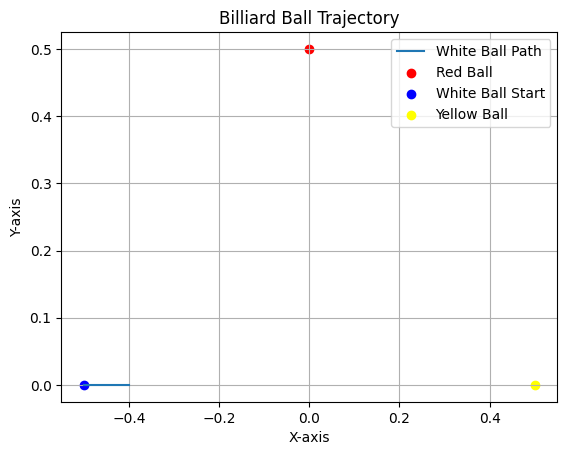

In [1]:
# 공의 경로 시각화

import pybullet as p
import matplotlib.pyplot as plt

# 물리 서버 연결
physicsClient = p.connect(p.DIRECT)  # 비시각적 모드
p.setGravity(0, 0, -10)

# 당구공 로드
red_ball = p.loadURDF("/home/qpitprj/qfit_31111/mansoon/scenario01/billiard_red_ball.urdf", basePosition=[0, 0.5, 0.1])
white_ball = p.loadURDF("/home/qpitprj/qfit_31111/mansoon/scenario01/billiard_white_ball.urdf", basePosition=[-0.5, 0, 0.1])
yellow_ball = p.loadURDF("/home/qpitprj/qfit_31111/mansoon/scenario01/billiard_yellow_ball.urdf", basePosition=[0.5, 0, 0.1])

# 흰 공에 초기 속도 부여
p.applyExternalForce(white_ball, -1, forceObj=[10, 0, 0], posObj=[0, 0, 0], flags=p.WORLD_FRAME)

# 시뮬레이션 데이터 저장
positions = []
for i in range(100):
    p.stepSimulation()
    pos, _ = p.getBasePositionAndOrientation(white_ball)
    positions.append(pos)

# 물리 서버 연결 종료
p.disconnect()

# 공의 경로 시각화
x, y, z = zip(*positions)
plt.plot(x, y, label="White Ball Path")  # 흰 공의 경로
plt.scatter([0], [0.5], color="red", label="Red Ball")  # 빨간 공
plt.scatter([-0.5], [0], color="blue", label="White Ball Start")  # 흰 공 시작 위치
plt.scatter([0.5], [0], color="yellow", label="Yellow Ball")  # 노란 공
plt.legend()
plt.title("Billiard Ball Trajectory")  # 제목
plt.xlabel("X-axis")  # X축
plt.ylabel("Y-axis")  # Y축
plt.grid()
plt.show()
